In [1]:
import codecs, re, os

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate


In [2]:
def load_speaker(path="../data/raw/corpus.tache1.learn.utf8"):
    corpus = []
    classes = []
    f = codecs.open(path, "r", "utf-8")  # pour régler le codage
    while True:
        texte = f.readline()
        if (len(texte)) < 5:
            break
        label = re.sub(r"<\d*:\d*:(.)>.*", "\\1", texte)
        texte = re.sub(r"<\d*:\d*:.>(.*)", "\\1", texte)
        if label.count("M") > 0:
            classes.append(-1)
        else:
            classes.append(1)
        corpus.append(texte)
    return np.array(corpus), np.array(classes)

X, y = load_speaker()
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Comparing original vs oversampling vs undersampling vs balanced for our models


In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

def make_pipeline(mode, model):
    if mode == "original":
        return make_imb_pipeline(CountVectorizer(), model())
    elif mode == "oversampling":
        return make_imb_pipeline(CountVectorizer(), RandomOverSampler(), model())
    elif mode == "undersampling":
        return make_imb_pipeline(
            CountVectorizer(), RandomUnderSampler(replacement=False), model()
        )
    elif mode == "regularization" and model.__name__ != "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(class_weight="balanced"))
    elif "regularization" in mode and model.__name__ == "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(fit_prior=True))
    # elif mode == "balanced + regularization" and model.__name__ != "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(C=10))
    # elif mode == "balanced + regularization" and model.__name__ == "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(fit_prior=True, alpha=0.5))
    # elif mode == "balanced ++" and model.__name__ != "MultinomialNB":
    #     weights = {-1: 100000000, 1:1}
    #     return make_imb_pipeline(CountVectorizer(), model(class_weight=weights))

## Learning Curves

### Présidents

Sur les modèles bruts (sans avoir touché aux paramètres) :

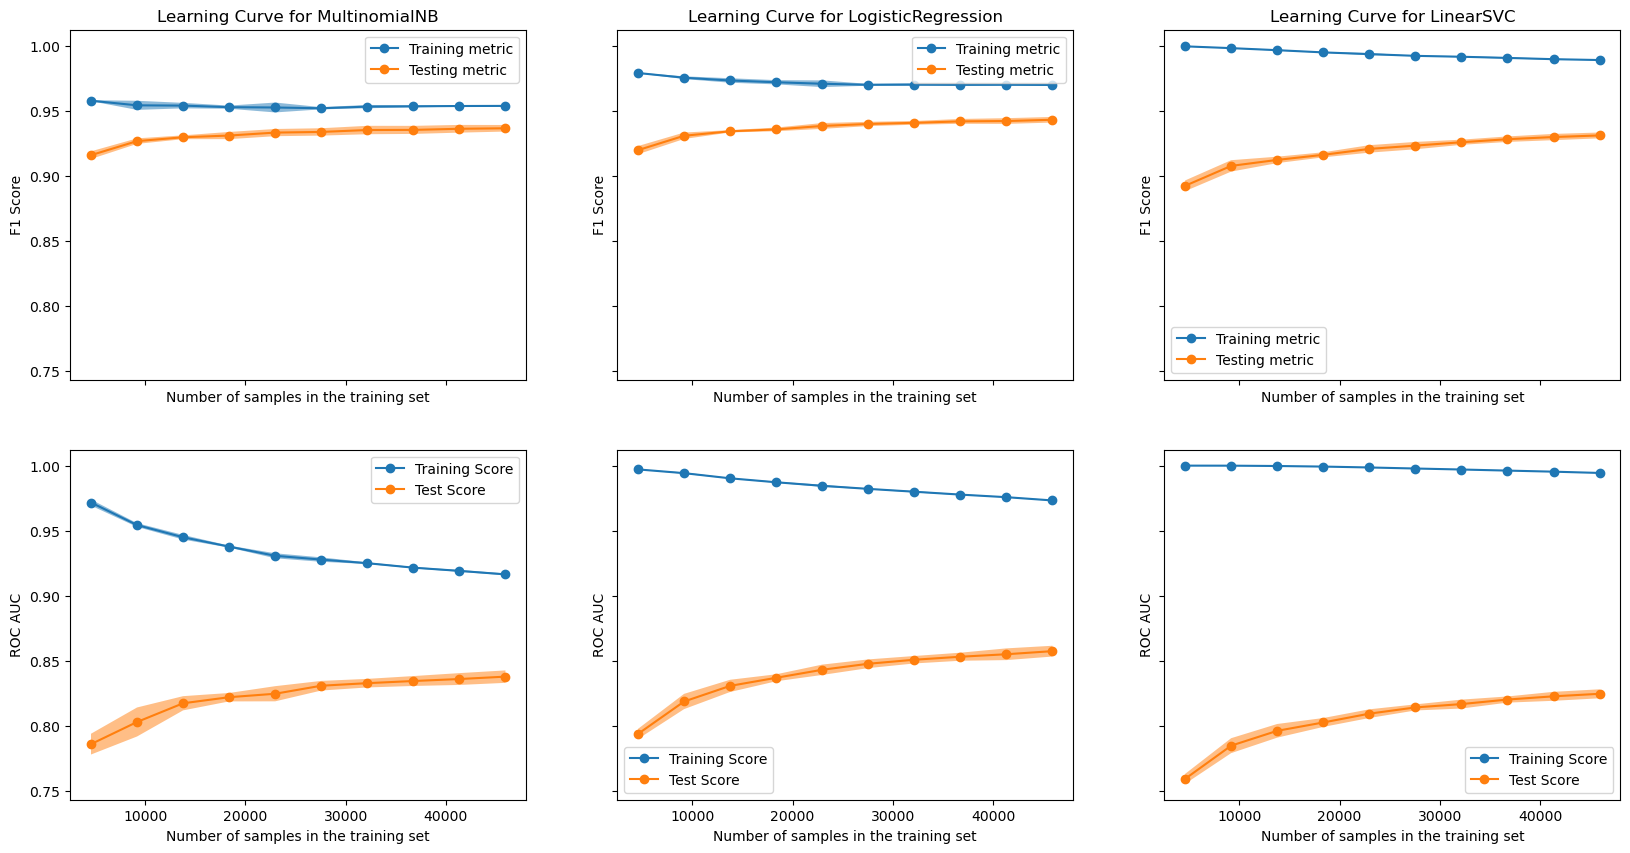

In [16]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

common_params_roc = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "roc_auc",
    "score_name": "ROC AUC",
}

common_params_f1 = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "f1",
    "score_name": "F1 Score",
}

models = [MultinomialNB, LogisticRegression, LinearSVC]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)

for ax_idx, model in enumerate(models):
    pipeline = make_pipeline("original", model)
    LearningCurveDisplay.from_estimator(pipeline, **common_params_f1, ax=ax[0, ax_idx])
    LearningCurveDisplay.from_estimator(pipeline, **common_params_roc, ax=ax[1, ax_idx])
    handles, label = ax[0, ax_idx].get_legend_handles_labels()
    ax[1, ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[0, ax_idx].set_title(f"Learning Curve for {model.__name__}")
plt.savefig("../reports/figures/learningcurve.png", dpi=100, bbox_inches="tight")

Après avoir optimisé les paramètres :

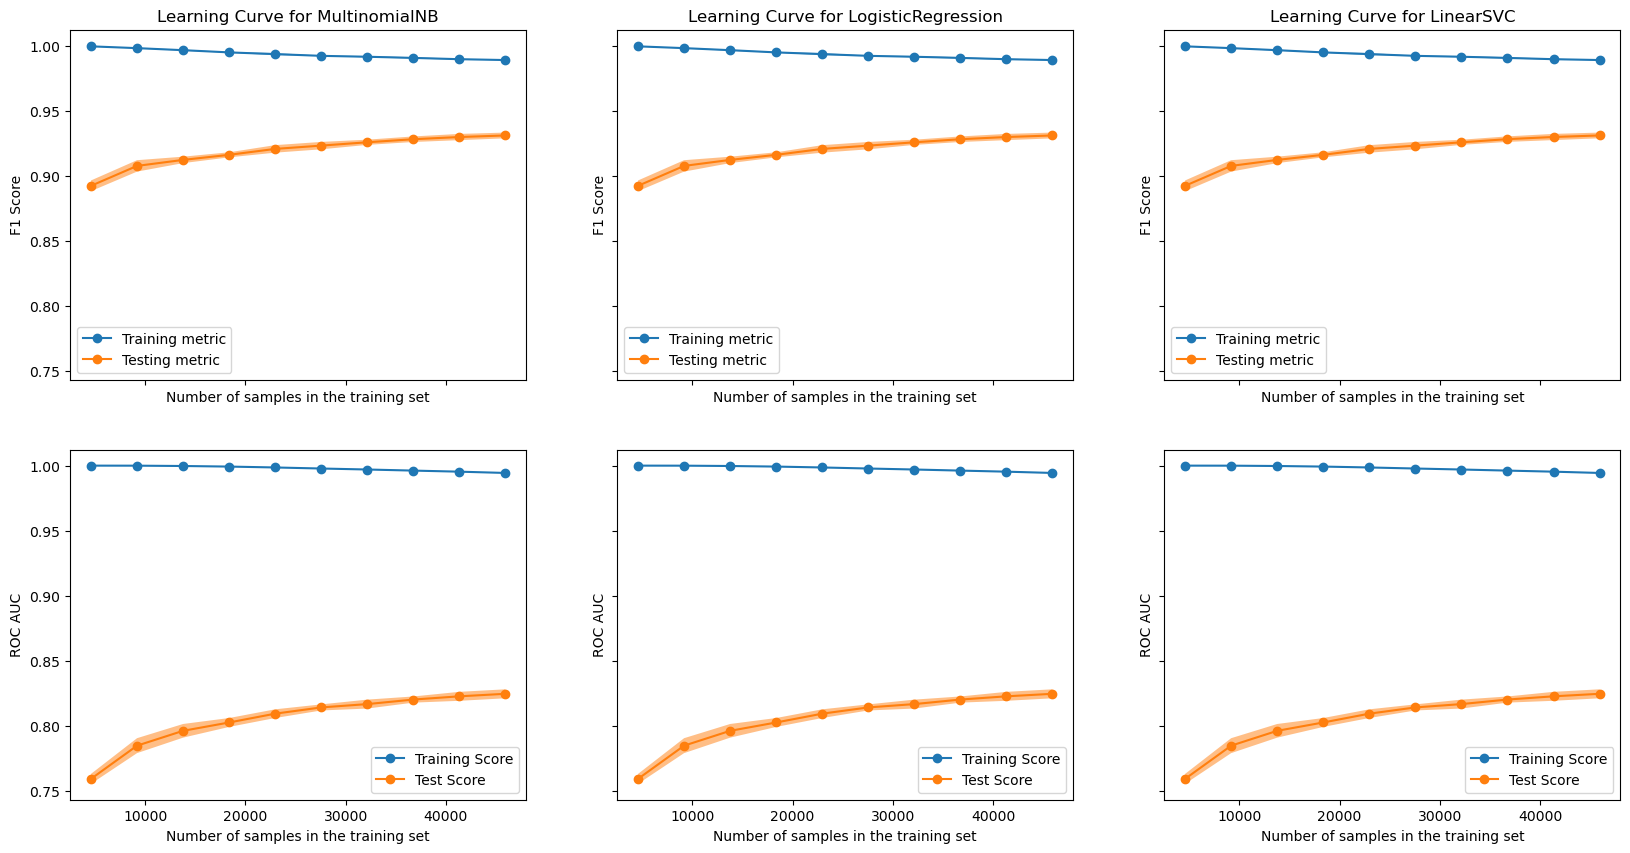

In [18]:
import joblib

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)

for ax_idx, model in enumerate(models):
    d = joblib.load(f"../gridsearch/results/part1_hrscv_{model.__name__}.pkl")
    LearningCurveDisplay.from_estimator(pipeline, **common_params_f1, ax=ax[0, ax_idx])
    LearningCurveDisplay.from_estimator(pipeline, **common_params_roc, ax=ax[1, ax_idx])
    handles, label = ax[0, ax_idx].get_legend_handles_labels()
    ax[1, ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[0, ax_idx].set_title(f"Learning Curve for {model.__name__}")
plt.savefig("../reports/figures/learningcurve_opti.png", dpi=100, bbox_inches="tight")

## Complexity analysis


In [23]:
from sklearn.model_selection import learning_curve

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "n_jobs": 6,
    "return_times": True,
    "scoring": "f1"
}

naive_bayes = make_pipeline("original", MultinomialNB)
lr = make_pipeline("original", LogisticRegression)
svc = make_pipeline("original", LinearSVC)

train_sizes, _, test_scores_nb, fit_times_nb, score_times_nb = learning_curve(
    naive_bayes, **common_params
)

train_sizes, _, test_scores_lr, fit_times_lr, score_times_lr = learning_curve(
    lr, **common_params
)
train_sizes, _, test_scores_svm, fit_times_svm, score_times_svm = learning_curve(
    svc, **common_params
)


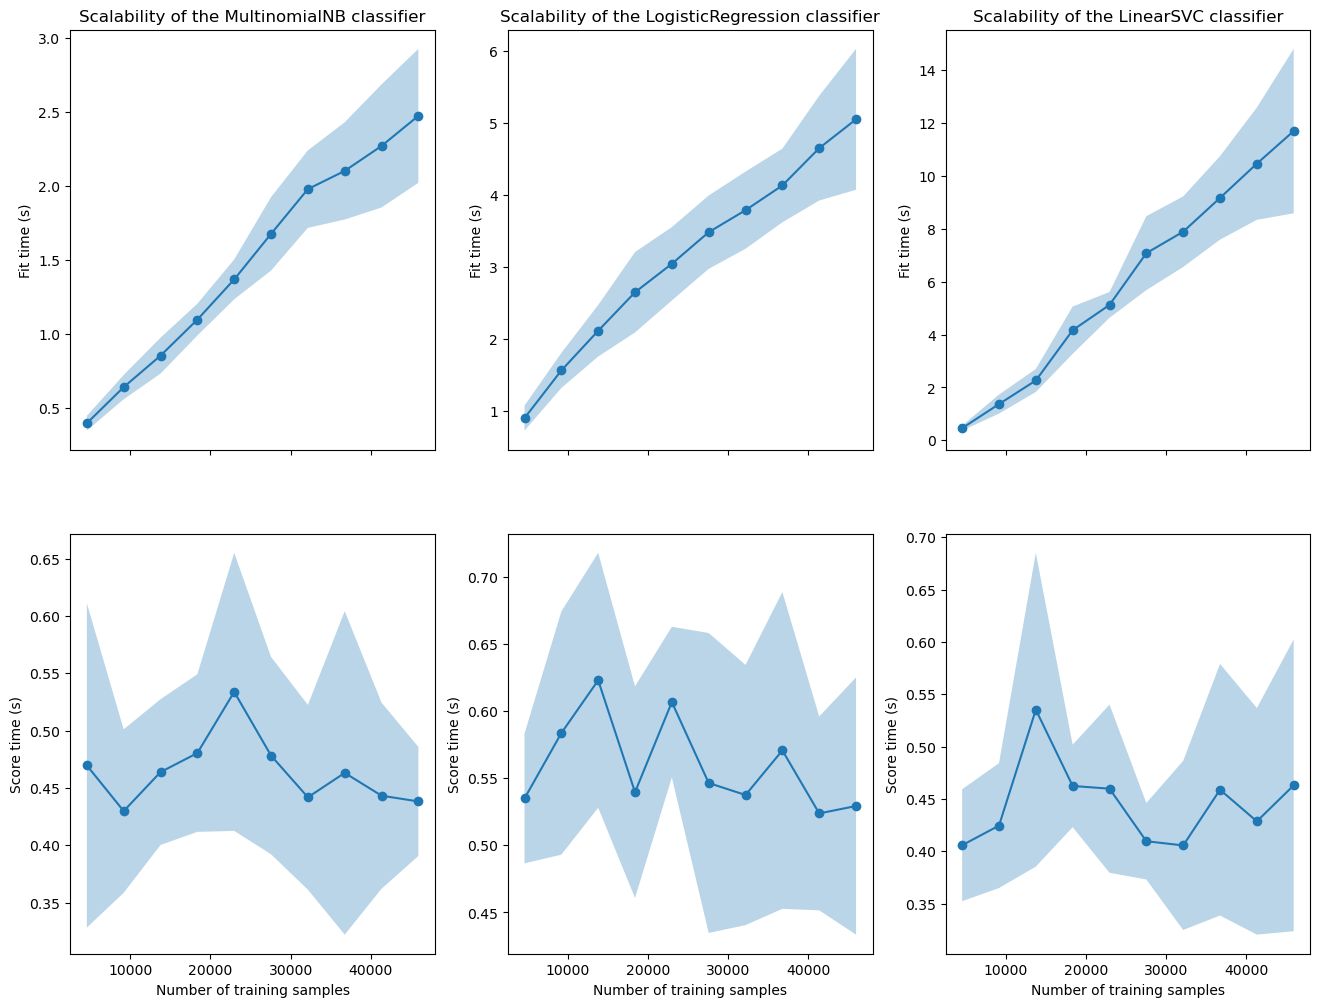

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 12), sharex=True)


for ax_idx, (fit_times, score_times, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_lr, fit_times_svm],
        [score_times_nb, score_times_lr, score_times_svm],
        ["MultinomialNB", "LogisticRegression", "LinearSVC"],
    )
):
    # scalability regarding the fit time
    ax[0, ax_idx].plot(train_sizes, fit_times.mean(axis=1), "o-")
    ax[0, ax_idx].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[0, ax_idx].set_ylabel("Fit time (s)")
    ax[0, ax_idx].set_title(
        f"Scalability of the {estimator} classifier"
    )

    # scalability regarding the score time
    ax[1, ax_idx].plot(train_sizes, score_times.mean(axis=1), "o-")
    ax[1, ax_idx].fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3,
    )
    ax[1, ax_idx].set_ylabel("Score time (s)")
    ax[1, ax_idx].set_xlabel("Number of training samples")

plt.savefig("../reports/figures/complexity_analysis_nsamples.png", dpi=100)

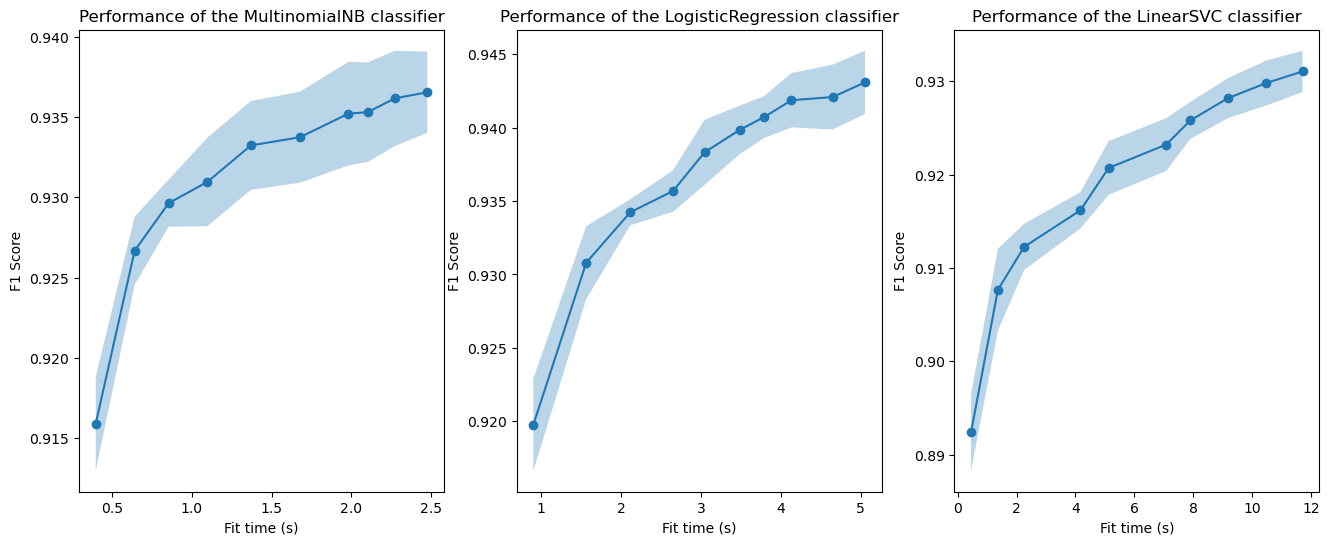

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

for ax_idx, (fit_times, test_scores, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_lr, fit_times_svm],
        [test_scores_nb, test_scores_lr, test_scores_svm],
        ["MultinomialNB", "LogisticRegression", "LinearSVC"],
    )
):
    ax[ax_idx].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("F1 Score")
    ax[ax_idx].set_xlabel("Fit time (s)")
    ax[ax_idx].set_title(
        f"Performance of the {estimator} classifier"
    )

plt.savefig("../reports/figures/complexity_analysis_accuracy.png", dpi=100)
plt.show()

## ROC-AUC Curves

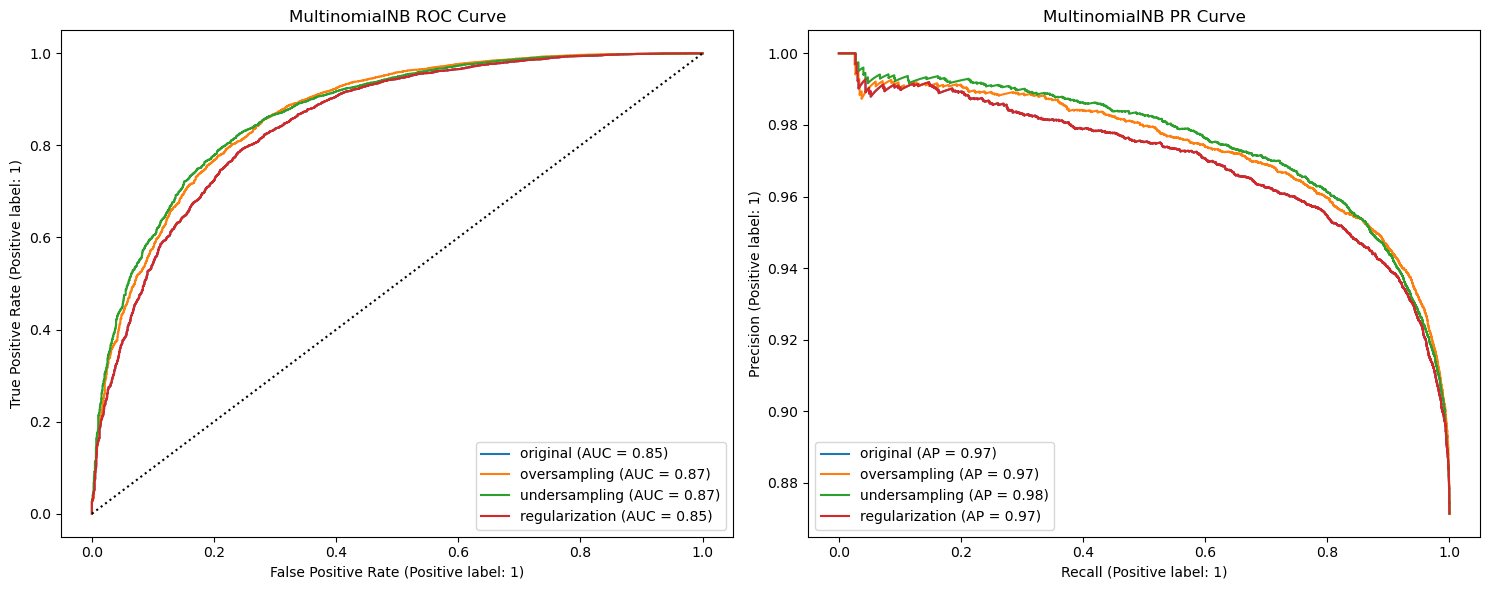

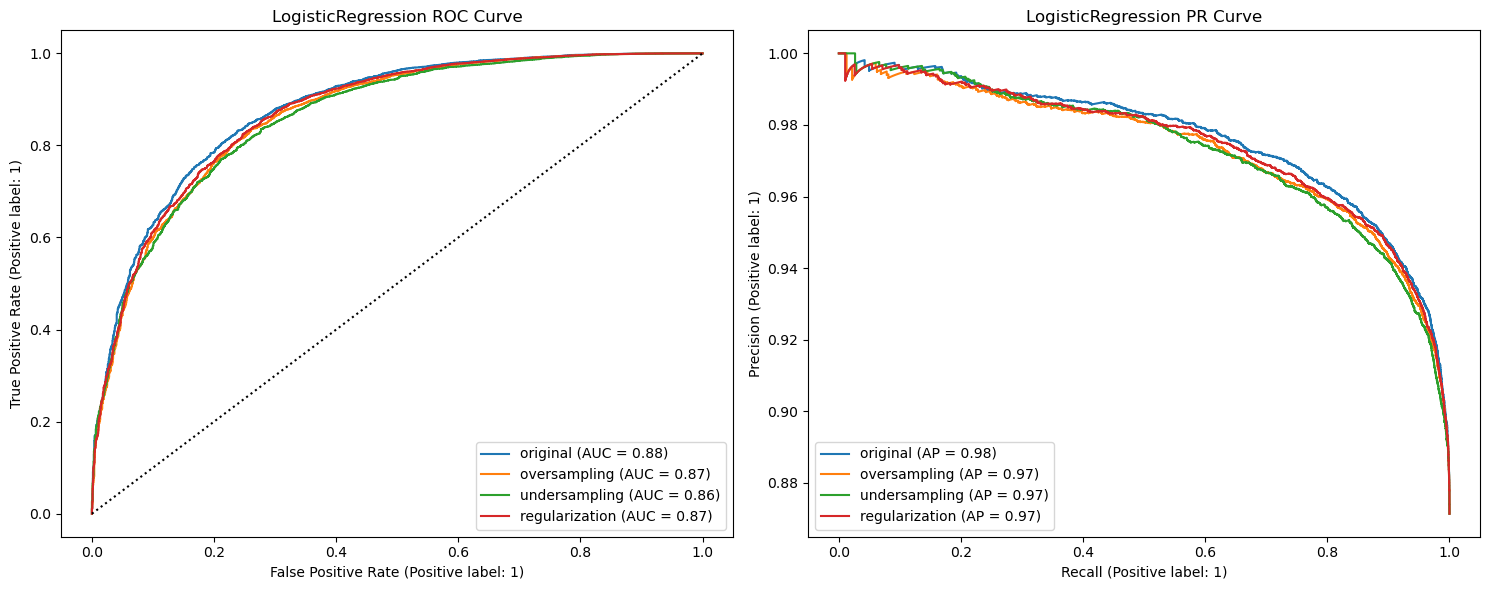

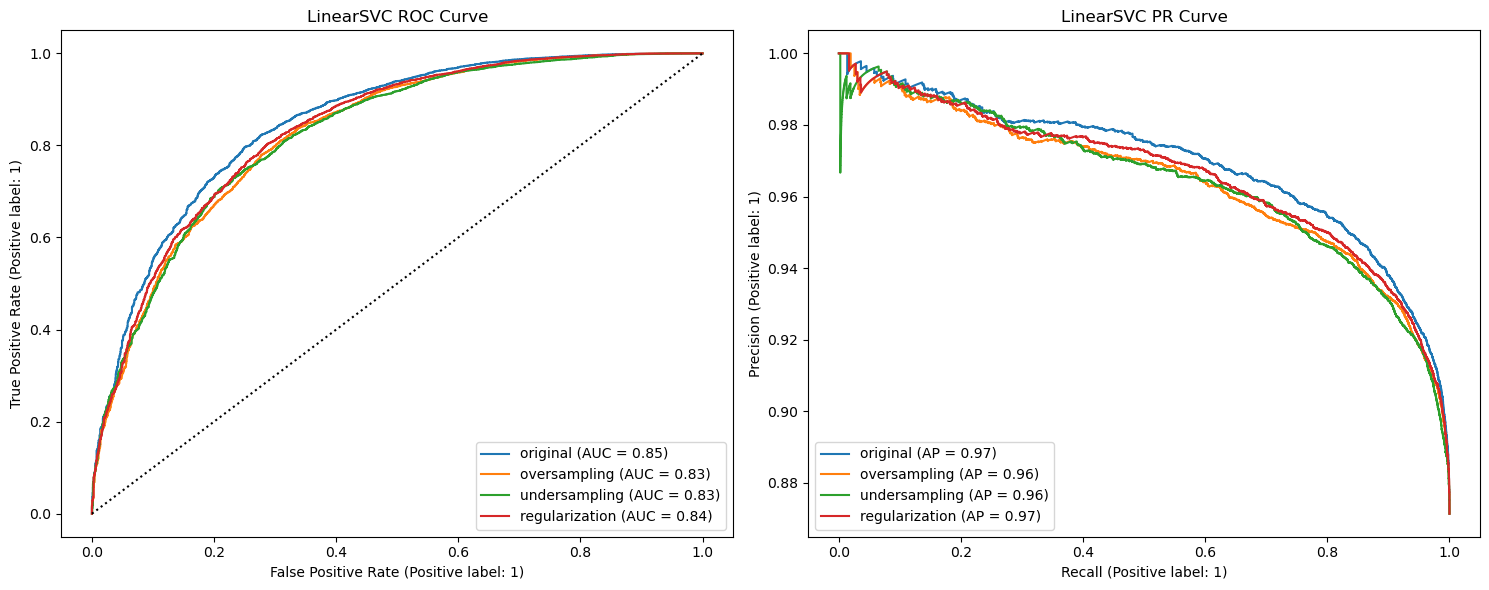

In [29]:
models = [MultinomialNB, LogisticRegression, LinearSVC]

sampler = ["original", "oversampling", "undersampling", "regularization"]

for i, model in enumerate(models):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_pipeline(sample, model)
        pipeline.fit(X_train, y_train)
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=sample, ax=ax[0])
        PrecisionRecallDisplay.from_estimator(
            pipeline, X_test, y_test, name=sample, ax=ax[1]
        )
    ax[0].set_title(f"{model.__name__} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{model.__name__} PR Curve")
    plt.tight_layout()
    plt.savefig(f"../reports/figures/roc_curve_{model.__name__}.png", dpi=100)
    plt.show()


## Les blocs !!!!

{'whiskers': [<matplotlib.lines.Line2D at 0x26031d4fa00>,
 'caps': [<matplotlib.lines.Line2D at 0x26031d4fe20>,
 'boxes': [<matplotlib.lines.Line2D at 0x26031d4f760>],
 'medians': [<matplotlib.lines.Line2D at 0x26031d583a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x26031d58640>],
 'means': []}

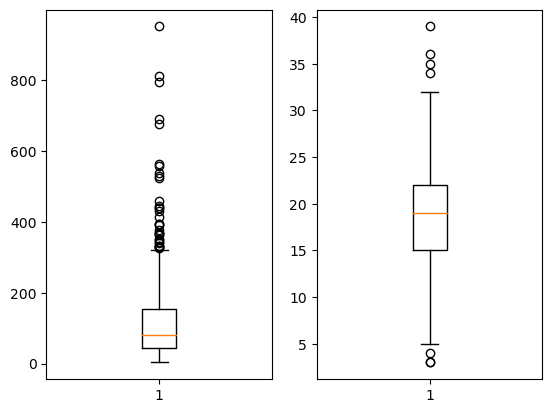

In [84]:
# import seaborn as sns

def nested_blocks(arr):
    blocks = []
    curr_block = []
    prev_val = None
    
    for val in arr:
        if val != prev_val:
            if curr_block:
                blocks.append(np.array(curr_block))
                curr_block = []
        curr_block.append(val)
        prev_val = val
    
    if curr_block:
        blocks.append(np.array(curr_block))
    
    return blocks

y_nested = nested_blocks(y)
mydict = {"Chirac": [len(block) for block in y_nested if np.all(block == 1)], "Mitterrand":[len(block) for block in y_nested if np.all(block == -1)]}

plt.subplot(121)
plt.boxplot(mydict["Chirac"])
plt.subplot(122)
plt.boxplot(mydict["Mitterrand"])


In [43]:
def nested_blocks(X, y):
    blocks = []
    curr_block = []
    prev_val = None
    change_points = [0]  # list of indices where a new block starts

    # iterate over the labels
    for i, val in enumerate(y):
        if val != prev_val:
            # if the value changes, start a new block
            if curr_block:
                blocks.append(
                    curr_block
                )  # add the previous block to the list of blocks
                curr_block = []  # reset the current block
                change_points.append(
                    i
                )  # add the index of the new block to the change points
        curr_block.append(val)  # add the current value to the current block
        prev_val = val  # set the previous value to the current value

    if curr_block:
        blocks.append(curr_block)  # add the last block to the list of block
        change_points.append(
            len(y)
        )  # add the index of the end of the array to the change points

    discours = []
    for block in blocks:
        # find the start and end indices of the current block in the original array
        start = y.tolist().index(block[0], change_points[blocks.index(block)])
        end = y.tolist().index(block[-1], start) + 1
        end = min(
            end, len(y)
        )  # make sure end is not larger than the length of the array
        # use the change points to get the corresponding lines from the lines array, 
        # and join them with spaces
        discours.append(
            " ".join(
                X[
                    change_points[blocks.index(block)] : change_points[
                        blocks.index(block) + 1
                    ]
                ]
            )
        )

    labels = [block[0] for block in blocks]

    assert len(discours) == len(labels)

    return discours, labels



X_nested, y_nested = nested_blocks(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_nested, y_nested)

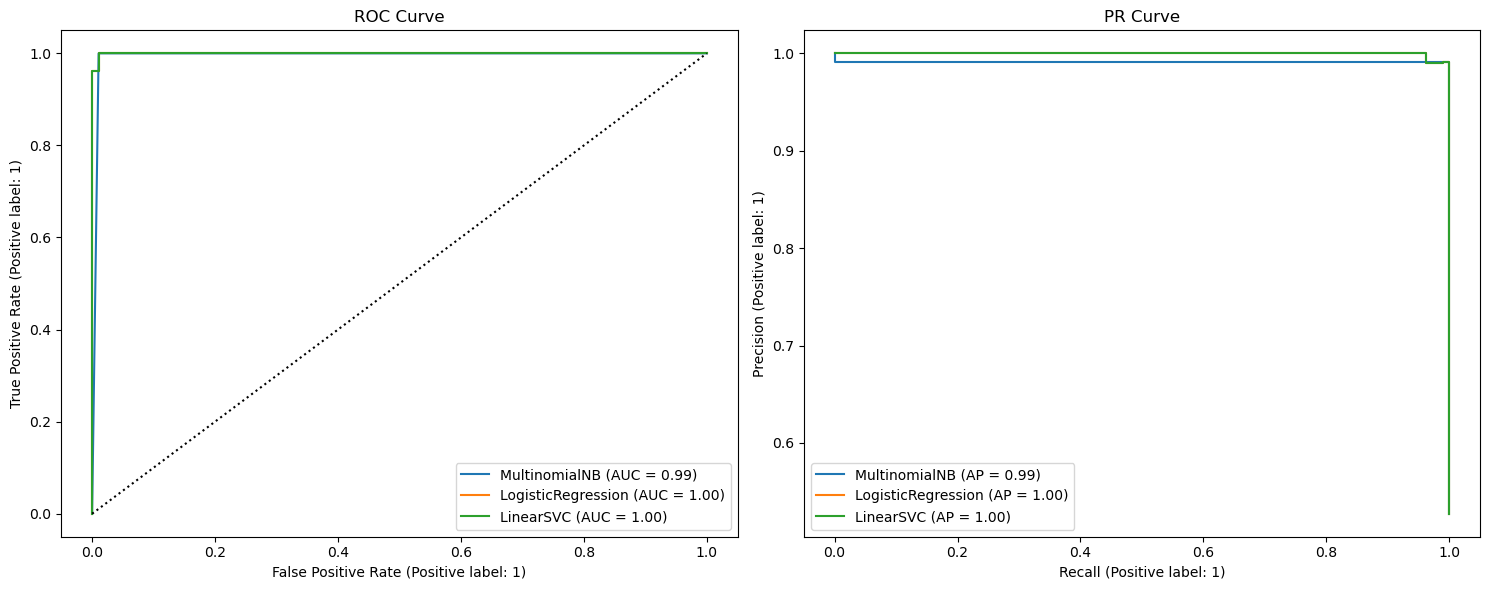

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_nested, y_nested)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    pipeline = make_pipeline("original", model)
    pipeline.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=model.__name__, ax=ax[0])
    PrecisionRecallDisplay.from_estimator(
        pipeline, X_test, y_test, name=model.__name__, ax=ax[1]
    )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig("roc_curve_blocks.png", dpi=100)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
y_onehot_test = pd.get_dummies(y_test).to_numpy()

classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):
    pipeline = make_imb_pipeline(CountVectorizer(), LogisticRegression())
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict_proba(X_test)
    RocCurveDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}", ax=ax[0])
    PrecisionRecallDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}", ax=ax[1])
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig("roc_curve_blocks_classes.png", dpi=100)
plt.show()

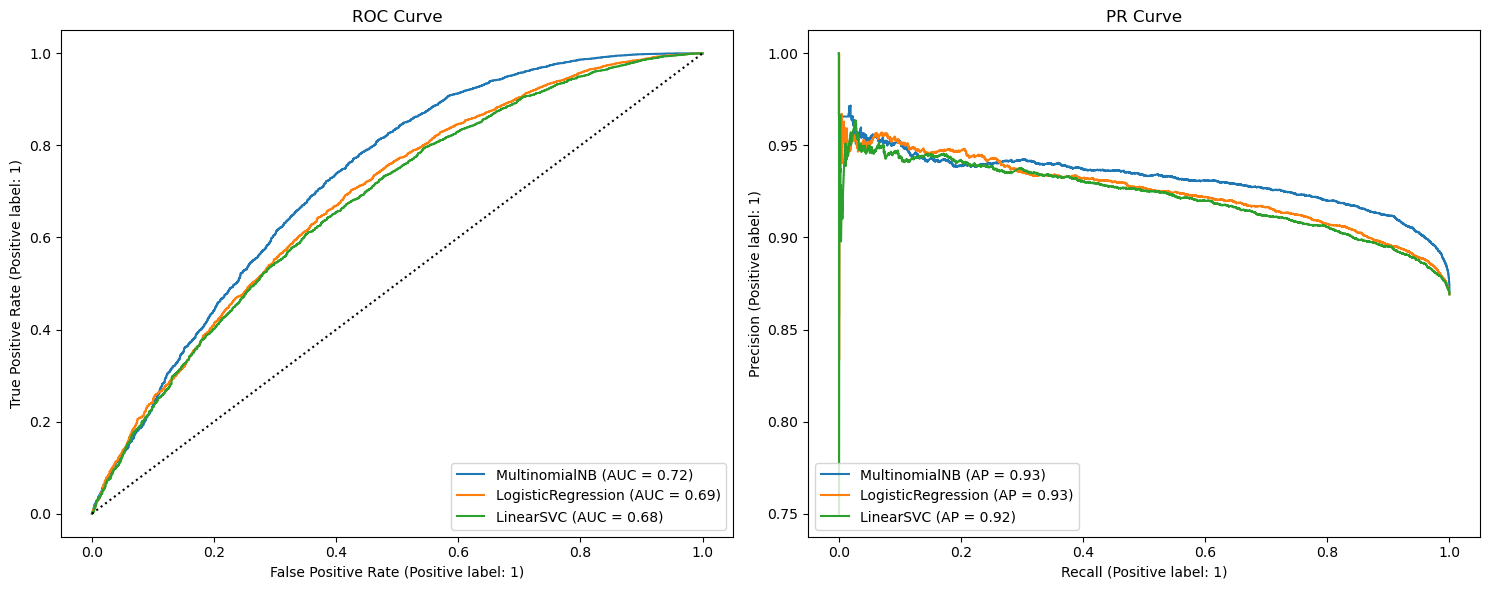

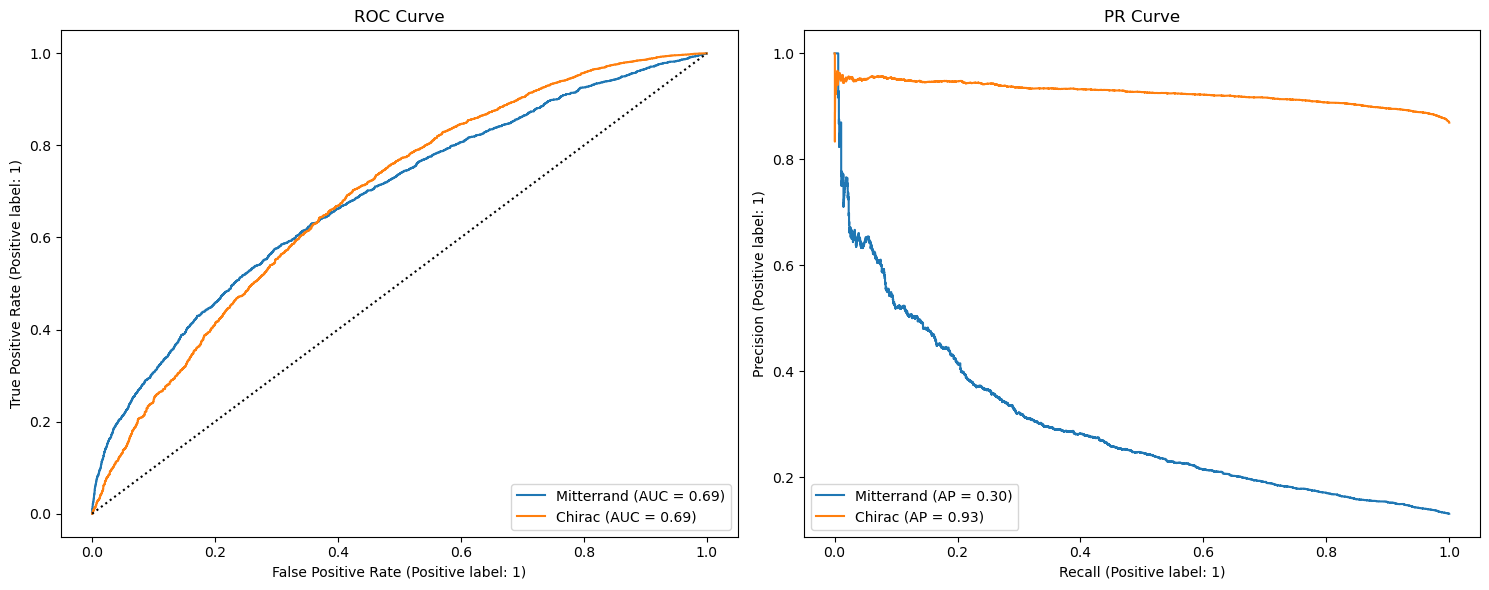

In [70]:
X, y = load_speaker()
_, X_test, _, y_test = train_test_split(X, y)
X_nested, y_nested = nested_blocks(X, y)
X_train, _, y_train, _ = train_test_split(X_nested, y_nested)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    pipeline = make_pipeline("original", model)
    pipeline.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=model.__name__, ax=ax[0])
    PrecisionRecallDisplay.from_estimator(
        pipeline, X_test, y_test, name=model.__name__, ax=ax[1]
    )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig("roc_curve_blocks2.png", dpi=100)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
y_onehot_test = pd.get_dummies(y_test).to_numpy()

classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):
    pipeline = make_imb_pipeline(CountVectorizer(), LogisticRegression())
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict_proba(X_test)
    RocCurveDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}", ax=ax[0])
    PrecisionRecallDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}", ax=ax[1])
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig("roc_curve_blocks_classes2.png", dpi=100)
plt.show()